In [1]:
!python --version

Python 3.10.13


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras as ks
from PIL import ImageFont
import visualkeras
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [5]:
dataset_train.Close = pd.to_numeric(dataset_train.Close.apply(lambda x: x.replace(',', '')))
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.1+ KB


In [6]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [7]:
training_set = dataset_train[['Close']]
testing_set = dataset_test[['Close']]

In [8]:
testing_set

,Close
0,786.14
1,786.90
2,794.02
3,806.15
4,806.65
5,804.79
6,807.91
7,806.36
8,807.88
9,804.61


In [9]:
training_set

,Close
0,663.59
1,666.45
2,657.21
3,648.24
4,620.76
...,...
1253,789.91
1254,791.55
1255,785.05
1256,782.79


In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [11]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
NO_DAYS = 180

for i in range(NO_DAYS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-NO_DAYS: i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
X_train

array([[0.23757287, 0.24151427, 0.22878051, ..., 0.29841655, 0.29882998,
        0.31022698],
       [0.24151427, 0.22878051, 0.21641884, ..., 0.29882998, 0.31022698,
        0.32290561],
       [0.22878051, 0.21641884, 0.1785483 , ..., 0.31022698, 0.32290561,
        0.32376004],
       ...,
       [0.35902595, 0.36106556, 0.36905861, ..., 0.41351653, 0.41165608,
        0.41391618],
       [0.36106556, 0.36905861, 0.37954605, ..., 0.41165608, 0.41391618,
        0.40495845],
       [0.36905861, 0.37954605, 0.36207158, ..., 0.41391618, 0.40495845,
        0.40184391]])

In [13]:
y_train

array([0.32290561, 0.32376004, 0.331822  , ..., 0.40495845, 0.40184391,
       0.38672602])

In [14]:
X_train.shape

(1078, 180)

In [15]:
y_train.shape

(1078,)

In [16]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
X_train

array([[[0.23757287],
        [0.24151427],
        [0.22878051],
        ...,
        [0.29841655],
        [0.29882998],
        [0.31022698]],

       [[0.24151427],
        [0.22878051],
        [0.21641884],
        ...,
        [0.29882998],
        [0.31022698],
        [0.32290561]],

       [[0.22878051],
        [0.21641884],
        [0.1785483 ],
        ...,
        [0.31022698],
        [0.32290561],
        [0.32376004]],

       ...,

       [[0.35902595],
        [0.36106556],
        [0.36905861],
        ...,
        [0.41351653],
        [0.41165608],
        [0.41391618]],

       [[0.36106556],
        [0.36905861],
        [0.37954605],
        ...,
        [0.41165608],
        [0.41391618],
        [0.40495845]],

       [[0.36905861],
        [0.37954605],
        [0.36207158],
        ...,
        [0.41391618],
        [0.40495845],
        [0.40184391]]])

In [18]:
X_train.shape

(1078, 180, 1)

In [19]:
# Initialising the RNN

NO_NEURONS = 50

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [20]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 180, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

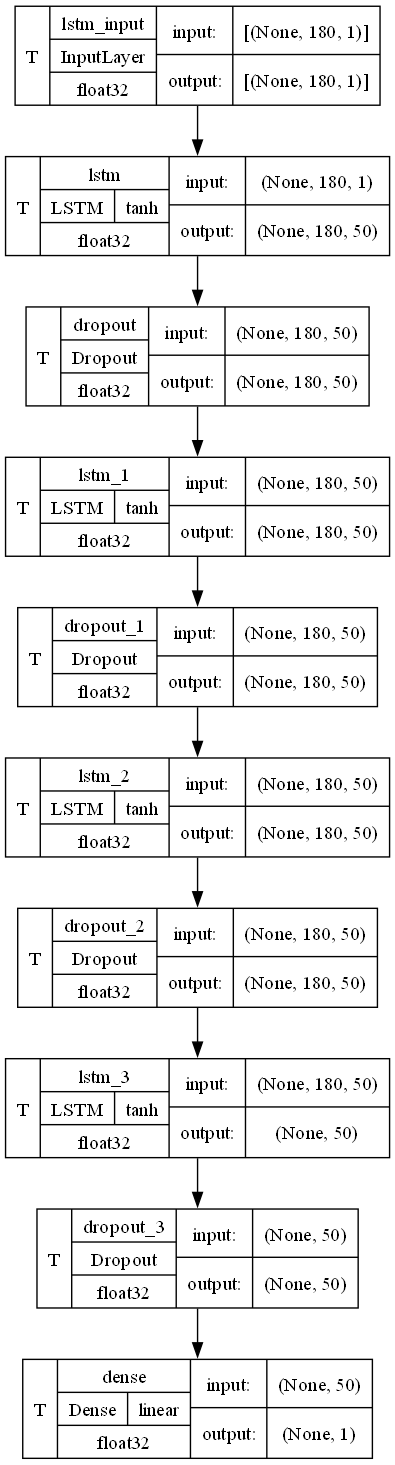

In [21]:
ks.utils.plot_model(
    regressor,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True,
)

In [22]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
34/34 [==============================] - 9s 128ms/step - loss: 0.0367
Epoch 2/100
34/34 [==============================] - 4s 121ms/step - loss: 0.0113
Epoch 3/100
34/34 [==============================] - 4s 117ms/step - loss: 0.0099
Epoch 4/100
34/34 [==============================] - 4s 116ms/step - loss: 0.0092
Epoch 5/100
34/34 [==============================] - 4s 115ms/step - loss: 0.0080
Epoch 6/100
34/34 [==============================] - 4s 116ms/step - loss: 0.0072
Epoch 7/100
34/34 [==============================] - 4s 116ms/step - loss: 0.0063
Epoch 8/100
34/34 [==============================] - 4s 116ms/step - loss: 0.0062
Epoch 9/100
34/34 [==============================] - 4s 118ms/step - loss: 0.0062
Epoch 10/100
34/34 [==============================] - 4s 117ms/step - loss: 0.0064
Epoch 11/100
34/34 [==============================] - 4s 117ms/step - loss: 0.0060
Epoch 12/100
34/34 [==============================] - 4s 119ms/step - loss: 0.0053
Epoch 13/100


In [24]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - NO_DAYS:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs.shape

C:\Users\mahmo\anaconda3\envs\tf2_10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(200, 1)

In [25]:
X_test = []

for i in range(NO_DAYS, len(inputs)):
    X_test.append(inputs[i-NO_DAYS:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)

1/1 [==============================] - 1s 952ms/step


In [26]:
X_test.shape

(20, 180, 1)

In [27]:
X_test

array([[[0.37107066],
        [0.38354258],
        [0.3676805 ],
        ...,
        [0.41687913],
        [0.4025881 ],
        [0.40178879]],

       [[0.38354258],
        [0.3676805 ],
        [0.36406984],
        ...,
        [0.4025881 ],
        [0.40178879],
        [0.39635903]],

       [[0.3676805 ],
        [0.36406984],
        [0.32399432],
        ...,
        [0.40178879],
        [0.39635903],
        [0.40952   ]],

       ...,

       [[0.32001158],
        [0.31126056],
        [0.30419084],
        ...,
        [0.45629315],
        [0.46638094],
        [0.47766768]],

       [[0.31126056],
        [0.30419084],
        [0.30033213],
        ...,
        [0.46638094],
        [0.47766768],
        [0.47339553]],

       [[0.30419084],
        [0.30033213],
        [0.30978598],
        ...,
        [0.47766768],
        [0.47339553],
        [0.44576437]]])

In [28]:
y_pred

array([[790.94885],
       [787.3789 ],
       [787.36896],
       [788.8376 ],
       [792.6596 ],
       [799.6615 ],
       [806.5818 ],
       [810.0624 ],
       [811.0841 ],
       [811.03796],
       [810.64935],
       [810.01117],
       [809.35065],
       [809.5307 ],
       [810.3174 ],
       [815.5051 ],
       [823.78894],
       [833.13354],
       [838.93774],
       [834.5622 ]], dtype=float32)

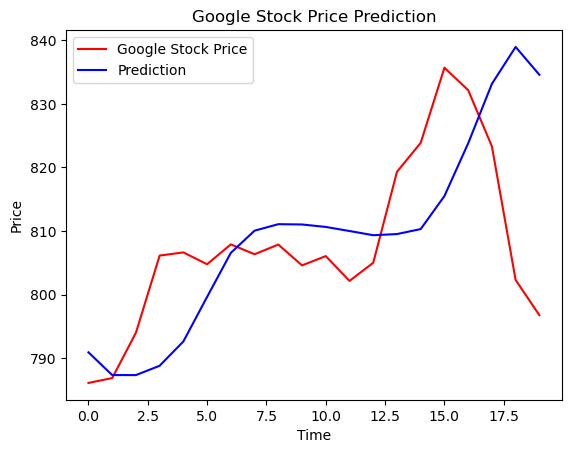

In [29]:
# Visualising the results

plt.plot(testing_set, color = 'red', label = 'Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Prediction')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [30]:
# CLASSIFICATION TEST

In [31]:
X_train.shape

(1078, 180, 1)

In [32]:
X_train

array([[[0.23757287],
        [0.24151427],
        [0.22878051],
        ...,
        [0.29841655],
        [0.29882998],
        [0.31022698]],

       [[0.24151427],
        [0.22878051],
        [0.21641884],
        ...,
        [0.29882998],
        [0.31022698],
        [0.32290561]],

       [[0.22878051],
        [0.21641884],
        [0.1785483 ],
        ...,
        [0.31022698],
        [0.32290561],
        [0.32376004]],

       ...,

       [[0.35902595],
        [0.36106556],
        [0.36905861],
        ...,
        [0.41351653],
        [0.41165608],
        [0.41391618]],

       [[0.36106556],
        [0.36905861],
        [0.37954605],
        ...,
        [0.41165608],
        [0.41391618],
        [0.40495845]],

       [[0.36905861],
        [0.37954605],
        [0.36207158],
        ...,
        [0.41391618],
        [0.40495845],
        [0.40184391]]])

In [33]:
y_train

array([0.32290561, 0.32376004, 0.331822  , ..., 0.40495845, 0.40184391,
       0.38672602])

In [34]:
y_train.shape

(1078,)

In [35]:
y_train_binary = []
for index, row in enumerate(X_train):
    if row[-1] >= y_train[index]:
        y_train_binary.append(1)
    else:
        y_train_binary.append(0)

In [36]:
y_train_binary = np.array(y_train_binary)

In [37]:
y_train_binary

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
y_train_binary.shape

(1078,)

In [39]:
# TEST DATASET


In [40]:
# Initialising the RNN

NO_NEURONS = 50

clf = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
clf.add(LSTM(units = NO_NEURONS, return_sequences=True, input_shape=(X_train.shape[1], 1)))
clf.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
clf.add(LSTM(units = NO_NEURONS, return_sequences = True))
clf.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
clf.add(LSTM(units = NO_NEURONS, return_sequences = True))
clf.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
clf.add(LSTM(units = NO_NEURONS))
clf.add(Dropout(0.2))

# Adding the output layer
clf.add(Dense(units = 1, activation='sigmoid'))

In [41]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 180, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_5 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_6 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_6 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

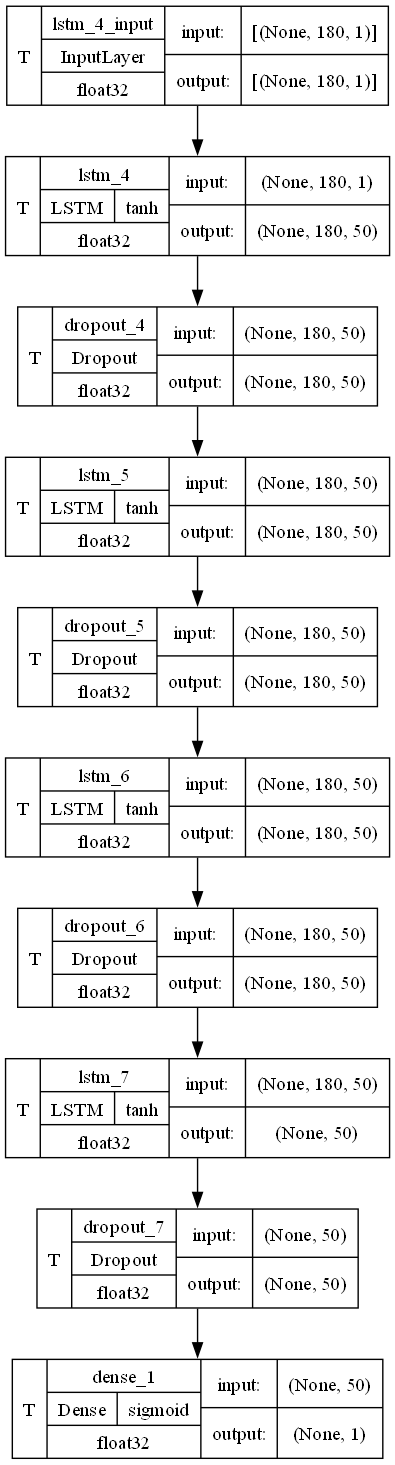

In [42]:
ks.utils.plot_model(
    clf,
    to_file="model_clf.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True,
)

In [43]:
clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics='accuracy')

In [44]:
# Fitting the RNN to the Training set
clf.fit(X_train, y_train_binary, epochs = 5, batch_size = 1)

Epoch 1/5
1078/1078 [==============================] - 69s 61ms/step - loss: 0.6993 - accuracy: 0.5083
Epoch 2/5
1078/1078 [==============================] - 65s 61ms/step - loss: 0.7038 - accuracy: 0.4963
Epoch 3/5
1078/1078 [==============================] - 65s 61ms/step - loss: 0.6993 - accuracy: 0.5037
Epoch 4/5
1078/1078 [==============================] - 66s 62ms/step - loss: 0.6993 - accuracy: 0.4787
Epoch 5/5
1078/1078 [==============================] - 66s 61ms/step - loss: 0.6957 - accuracy: 0.4944


In [45]:
# ADDING DIMENSIONS TO LSTM

In [46]:
new_training_set = dataset_train[['Close', 'Open', 'High', 'Low']]

scn = MinMaxScaler(feature_range = (0, 1))
new_training_set_scaled = scn.fit_transform(new_training_set)

NO_DAYS_FUTURE = 1
NO_FEATURES = new_training_set_scaled.shape[1]

z = series_to_supervised(data=new_training_set_scaled, n_in=NO_DAYS, n_out=NO_DAYS_FUTURE).to_numpy()

# split into input and outputs
n_obs = NO_DAYS * NO_FEATURES
train_X, train_y = z[:, :n_obs], z[:, -NO_FEATURES]
train_X = train_X.reshape((train_X.shape[0], NO_DAYS, NO_FEATURES))
print(train_X.shape, len(train_X), train_y.shape)

(1078, 180, 4) 1078 (1078,)


In [47]:
# Initialising the RNN

NO_NEURONS = 50

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = NO_NEURONS))
regressor.add(Dropout(0.2))

# Adding the output layer
# regressor.add(Dense(units = 1))
regressor.add(Dense(units = 1, activation='sigmoid'))

In [48]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 180, 50)           11000     
                                                                 
 dropout_8 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_9 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 180, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

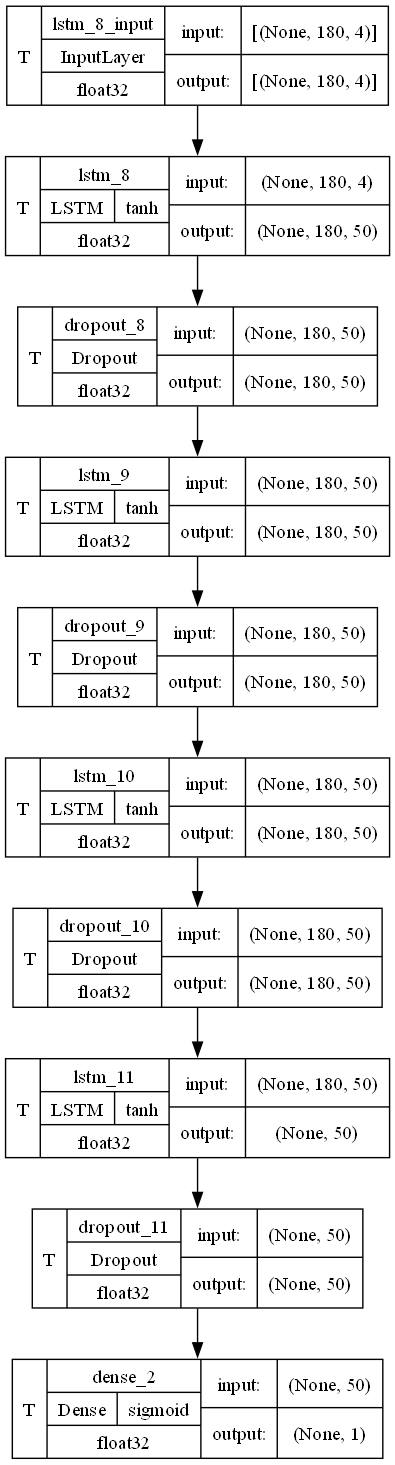

In [49]:
ks.utils.plot_model(
    regressor,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True,
)

In [50]:
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics='accuracy')

In [ ]:
# Fitting the RNN to the Training set
regressor.fit(train_X, y_train_binary, epochs = 5, batch_size = 1)

Epoch 1/5
1078/1078 [==============================] - 68s 63ms/step - loss: 0.6971 - accuracy: 0.4861
Epoch 2/5
1078/1078 [==============================] - 68s 63ms/step - loss: 0.7014 - accuracy: 0.5111
Epoch 3/5
1078/1078 [==============================] - 68s 63ms/step - loss: 0.6985 - accuracy: 0.4954
Epoch 4/5
 661/1078 [=================>............] - ETA: 26s - loss: 0.6995 - accuracy: 0.5204